## Benchmarking Neural IPF against Standard IPF

In [17]:
# Import libraries
import sys
import os
import numpy as np
import pandas as pd
import random
import timeit
import matplotlib.pyplot as plt
import torch
# import itertools
# from scipy.stats import pearsonr

# Set working directory to the project root directory where the imported modules are located
os.chdir('/Users/william/Google Drive/gradschool/PhD/Research/Dissertation/implementations')
from nipf_utils import nipf, plot_loss_trace, compute_marginals as nipf_marginals
from nipf_utils import nipf2
from ipf_net_inference_utils import (
        generate_X, generate_row_and_col_factors,
        generate_hourly_network,
        visualize_ipf_vs_poisson_params,
        eval_est_mat, do_ipf
    )

# Here is a bit of magic to reload external python modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Wikipedia IPF Article Example

> Link to the Wikipedia article: https://en.wikipedia.org/wiki/Iterative_proportional_fitting


### NIPF

Starting NIPF training...
Epoch 100 | Loss: 4.560264e-01
Epoch 200 | Loss: 1.192477e-05
NIPF training completed in 0.03 seconds.
tensor([[ 64.5590,  46.2320,  35.3840,   3.8250],
        [ 49.9680,  68.1590, 156.4980,  25.3740],
        [ 56.7220, 144.4280, 145.0820,  53.7680],
        [ 28.7520,  41.1800,  63.0350,  17.0340]])
[tensor([150.0002, 299.9992, 399.9989, 149.9997]), tensor([199.9996, 299.9987, 399.9993, 100.0004])]
Plot saved to ./experiments/nnipf/figs/wiki_loss_trace_0.1lr.png


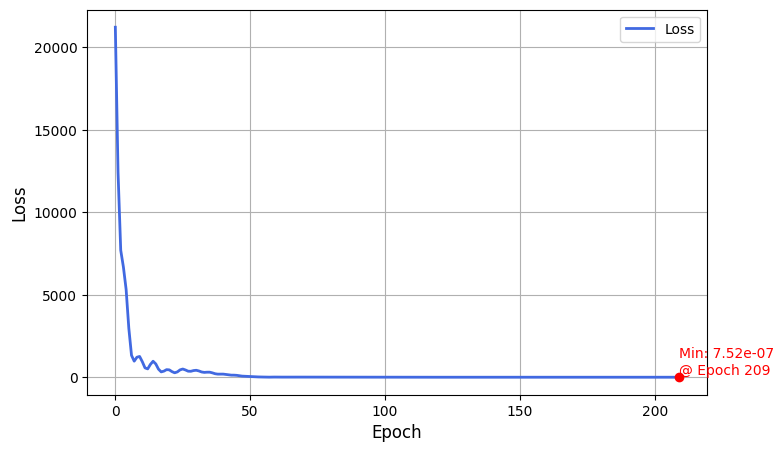

In [ ]:
# Initialize the seed table
# Result is deterministic so no need to set the seed
wiki_table = torch.tensor([
    [40, 30, 20, 10],
    [35, 50, 100, 75],
    [30, 80, 70, 120],
    [20, 30, 40, 50]]
)
# Define the target marginals
row_tgt = torch.tensor([150, 300, 400, 150])
col_tgt = torch.tensor([200, 300, 400, 100])
# Define the target marginals as a list of tensors
target_2d = [row_tgt, col_tgt]

# Train the model
import timeit
start_time = timeit.default_timer()
print("Starting NIPF training...")
wiki_table_adjusted, wiki_loss_trace = nipf(wiki_table, target_2d, epochs=1000, tol=1e-6, lr=0.1)
end_time = timeit.default_timer()
print(f"NIPF training completed in {end_time - start_time:.2f} seconds.")
print(torch.round(wiki_table_adjusted, decimals=3))
print(nipf_marginals(wiki_table_adjusted))

# Plot the loss trace
plot_loss_trace(wiki_loss_trace, save_path='./experiments/nnipf/figs/wiki_loss_trace_0.1lr.png')

#### With lr = 0.01

In [3]:
# Making sure the input table was not modified from the first training
print(wiki_table)

tensor([[ 40,  30,  20,  10],
        [ 35,  50, 100,  75],
        [ 30,  80,  70, 120],
        [ 20,  30,  40,  50]])


Starting NIPF training with lr=0.01...
Epoch 100 | Loss: 4.140260e+02
Epoch 200 | Loss: 3.030787e+01
Epoch 300 | Loss: 2.008872e+00
Epoch 400 | Loss: 8.929302e-02
Epoch 500 | Loss: 2.298249e-03
Epoch 600 | Loss: 3.155030e-05
NIPF training with lr=0.01 completed in 0.08 seconds.
tensor([[ 64.5590,  46.2330,  35.3840,   3.8250],
        [ 49.9680,  68.1590, 156.4980,  25.3750],
        [ 56.7220, 144.4280, 145.0820,  53.7680],
        [ 28.7520,  41.1800,  63.0350,  17.0340]])
[tensor([150.0004, 300.0002, 400.0001, 150.0001]), tensor([199.9996, 299.9997, 399.9996, 100.0018])]
Plot saved to ./experiments/nnipf/figs/wiki_loss_trace_0.01lr.png


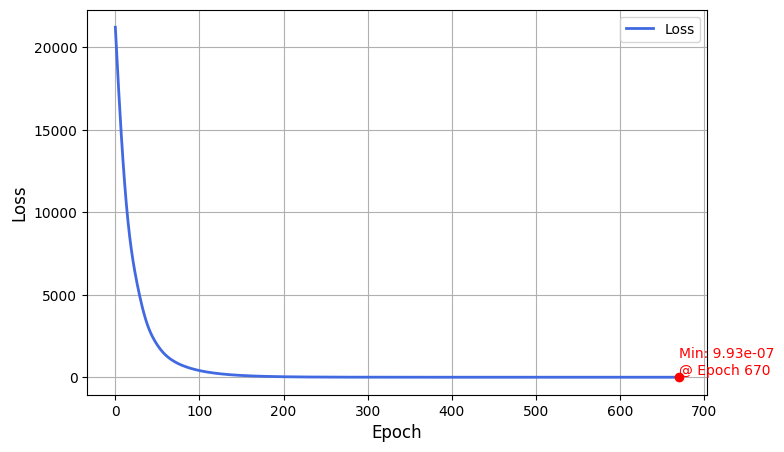

In [7]:
# Train the NIPF model with learning rate 0.01
start_time2 = timeit.default_timer()
print("Starting NIPF training with lr=0.01...")
wiki_table_adjusted2, wiki_loss_trace2 = nipf(wiki_table, target_2d, epochs=1000, tol=1e-6, lr=0.01)
end_time2 = timeit.default_timer()
print(f"NIPF training with lr=0.01 completed in {end_time2 - start_time2:.2f} seconds.")
print(torch.round(wiki_table_adjusted2, decimals=3))
print(nipf_marginals(wiki_table_adjusted2))

# Plot the loss trace for the second training
plot_loss_trace(wiki_loss_trace2, save_path='./experiments/nnipf/figs/wiki_loss_trace_0.01lr.png')

#### Confirming correctness of the scaling factors for the matrix case

$$\hat{X} = S^1 X S^2$$

Where $S^1$, and $S^2$ are the diagonal matrices whose diagonal elements correspond to the respective scaling factors.


In [8]:
# Train and return the scaling factors
wiki_table_adjusted2, scale_factors, wiki_loss_trace2 = nipf2(wiki_table, target_2d, epochs=1000, tol=1e-6, lr=0.1)
print(nipf_marginals(wiki_table_adjusted2))
print(scale_factors)

diagonal_matrices_np = [
    torch.diag(scale).cpu().numpy() for scale in scale_factors
]
S1_np = diagonal_matrices_np[0]  # Row scaling diagonal matrix (numpy)
S2_np = diagonal_matrices_np[1]  # Column scaling diagonal matrix (numpy)

# You can now compute adjusted matrix in NumPy as:
X_hat_np = S1_np @ wiki_table.cpu().numpy() @ S2_np
print(X_hat_np.sum(axis=1))
print(X_hat_np.sum(axis=0))

Epoch 100 | Loss: 4.560264e-01
Epoch 200 | Loss: 1.192477e-05
[tensor([150.0002, 299.9992, 399.9989, 149.9997]), tensor([199.9996, 299.9987, 399.9993, 100.0004])]
[tensor([1.0450, 0.9243, 1.2242, 0.9308]), tensor([1.5445, 1.4748, 1.6931, 0.3660])]
[150.00021777 299.99919304 399.998919   149.99970734]
[199.99959847 299.99876276 399.99928636 100.00038955]


### IPF

- We compare the results to classical IPF solution

In [10]:
wiki_table_np = wiki_table_adjusted.numpy()
target_2d_np = [t.numpy() for t in target_2d]
# Compare results with IPF
wiki_table_adjusted_ipf = ipfn_wrapper(
    wiki_table_np.copy(), target_2d_np, convergence_rate=1e-6
    )
print(wiki_table_adjusted_ipf)
print(compute_marginals(wiki_table_adjusted_ipf))

[[ 64.55854989  46.23249617  35.38432874   3.8247356 ]
 [ 49.96790402  68.15934118 156.49853526  25.37417792]
 [ 56.72192749 144.42820933 145.0824695   53.76734818]
 [ 28.75161859  41.17995331  63.0346665   17.0337383 ]]
[array([150.0001104 , 299.99995839, 399.99995451, 149.9999767 ]), array([200., 300., 400., 100.])]


### Compare Results

#### Estimated Cell Frequencies

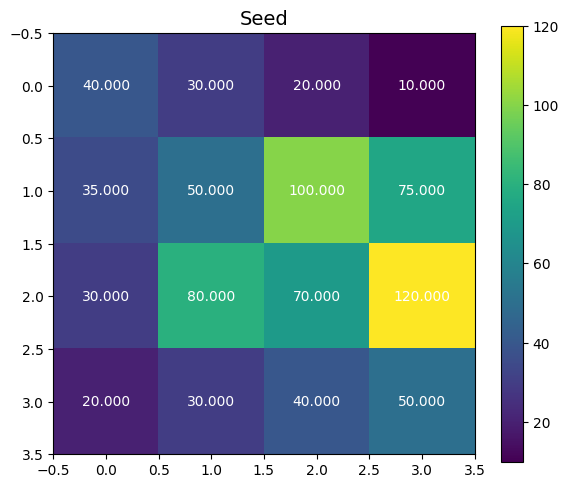

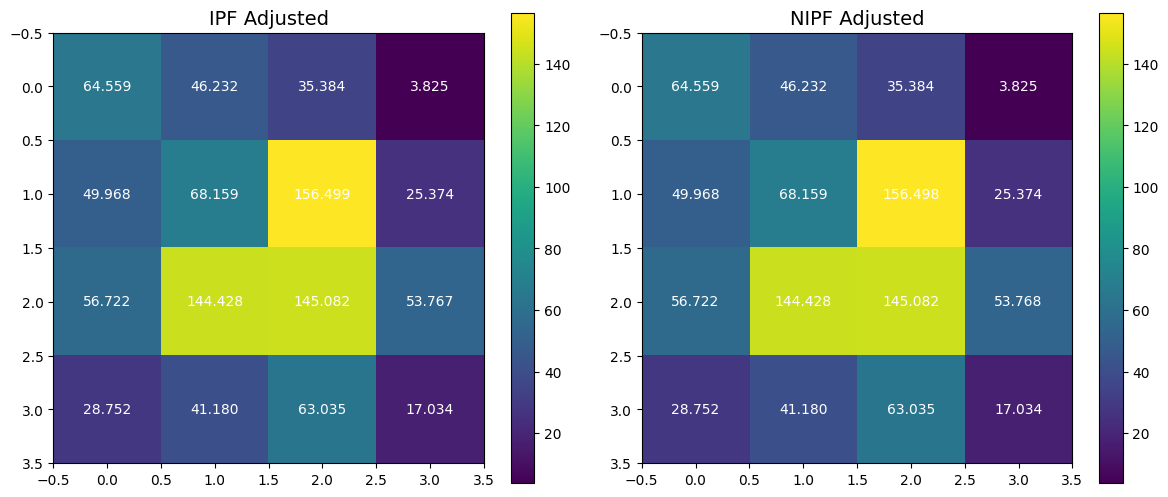

In [11]:
def plot_contingency_tables_heatmap(tables_dict, cmap='viridis', annotate=True, precision=2,
                                    save_path=None):
    """
    Plots 2D contingency tables as annotated heatmaps.

    Parameters:
        tables_dict (dict): {name: 2D numpy array}
        cmap (str): Matplotlib colormap
        annotate (bool): Whether to show numeric values on cells
        precision (int): Decimal places in annotation
        save_path (str): If provided, saves the figure to this path
    """
    num_tables = len(tables_dict)
    fig, axs = plt.subplots(1, num_tables, figsize=(6 * num_tables, 5))

    if num_tables == 1:
        axs = [axs]  # Make iterable

    for ax, (name, table) in zip(axs, tables_dict.items()):
        im = ax.imshow(table, cmap=cmap)
        ax.set_title(name, fontsize=14)
        # ax.set_xlabel("Columns")
        # ax.set_ylabel("Rows")

        if annotate:
            for i in range(table.shape[0]):
                for j in range(table.shape[1]):
                    val = f'{table[i, j]:.{precision}f}'
                    ax.text(j, i, val, ha='center', va='center', color='white')

        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot the original and adjusted tables

plot_contingency_tables_heatmap({
    'Seed': wiki_table.numpy(),
}, precision=3, save_path='./experiments/nnipf/figs/wiki_seed_heatmap.png')

plot_contingency_tables_heatmap({
    'IPF Adjusted': wiki_table_adjusted_ipf,
    'NIPF Adjusted': wiki_table_adjusted.numpy()
}, precision=3, save_path='./experiments/nnipf/figs/wiki_nipf_ipf_heatmap_01lr.png')

#### Margins

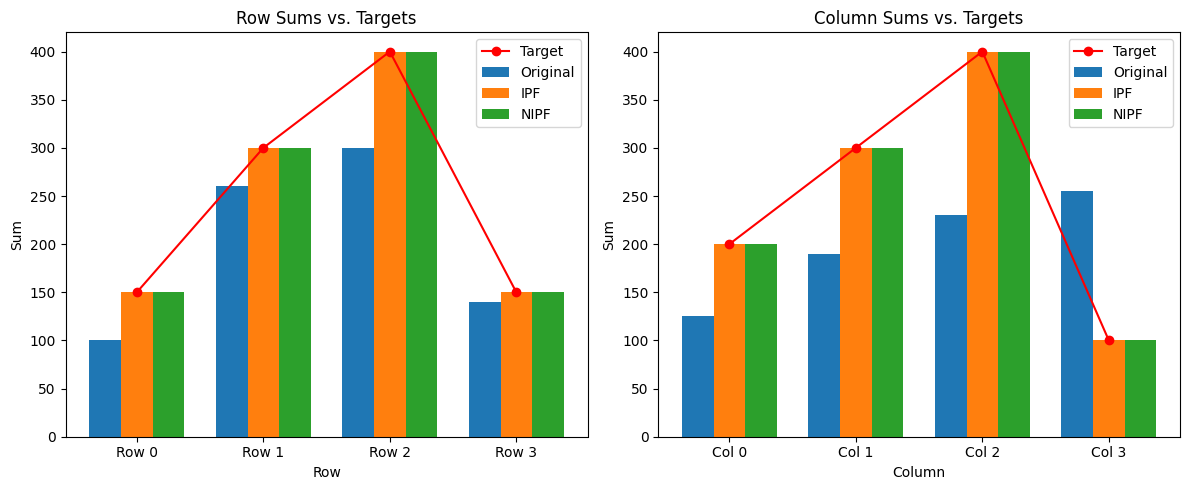

In [12]:
# Visualize the row and column sums compared to targets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Row sums
row_targets = row_tgt.numpy()
col_targets = col_tgt.numpy()
mtx = wiki_table.numpy()
x = np.arange(len(row_targets))
width = 0.25  # Reduce width for three bars

ax1.bar(x - width, mtx.sum(axis=1), width, label='Original')
ax1.bar(x, wiki_table_adjusted_ipf.sum(axis=1), width, label='IPF')
ax1.bar(x + width, wiki_table_adjusted.sum(axis=1), width, label='NIPF')  # Third estimate
ax1.plot(x, row_targets, 'ro-', label='Target')

ax1.set_xlabel('Row')
ax1.set_ylabel('Sum')
ax1.set_title('Row Sums vs. Targets')
ax1.set_xticks(x)
ax1.set_xticklabels([f'Row {i}' for i in range(len(row_targets))])
ax1.legend()

# Column sums
x = np.arange(len(col_targets))
ax2.bar(x - width, mtx.sum(axis=0), width, label='Original')
ax2.bar(x, wiki_table_adjusted_ipf.sum(axis=0), width, label='IPF')
ax2.bar(x + width, wiki_table_adjusted.sum(axis=0), width, label='NIPF')  # Third estimate
ax2.plot(x, col_targets, 'ro-', label='Target')

ax2.set_xlabel('Column')
ax2.set_ylabel('Sum')
ax2.set_title('Column Sums vs. Targets')
ax2.set_xticks(x)
ax2.set_xticklabels([f'Col {i}' for i in range(len(col_targets))])
ax2.legend()

plt.tight_layout()
plt.savefig('./experiments/nnipf/figs/wiki_margin_comparison_01lr.pdf', bbox_inches='tight')
plt.show()


In [13]:
from scipy.stats import chi2_contingency, entropy
from sklearn.metrics import mean_squared_error

def compute_all_metrics(seed_table, fitted_table_dict, target_marginals):
    """
    Compute evaluation metrics for multiple fitted tables against the seed table and target marginals.

    Parameters:
        seed_table (np.ndarray): Original contingency table (2D).
        fitted_table_dict (dict): {method_name: fitted_table (np.ndarray)}
        target_marginals (list of np.ndarray): [target_rows, target_cols]

    Returns:
        dict of dicts: {method_name: {metric_name: value, ...}, ...}
    """
    results = {}
    row_target, col_target = target_marginals

    for method, fitted_table in fitted_table_dict.items():
        row_sum = fitted_table.sum(axis=1)
        col_sum = fitted_table.sum(axis=0)

        rmse_row = mean_squared_error(row_target, row_sum)
        rmse_col = mean_squared_error(col_target, col_sum)

        chi2, _, _, _ = chi2_contingency(fitted_table)
        n = np.sum(fitted_table)
        min_dim = min(fitted_table.shape)
        cramers_v = np.sqrt(chi2 / (n * (min_dim - 1))) if min_dim > 1 else 0

        seed_flat = seed_table.flatten()
        fitted_flat = fitted_table.flatten()

        seed_dist = seed_flat / seed_flat.sum()
        fitted_dist = fitted_flat / fitted_flat.sum()

        kld = entropy(seed_dist, fitted_dist)
        

        results[method] = {
            "RMSE (Row Marginals)": rmse_row,
            "RMSE (Column Marginals)": rmse_col,
            "Chi-squared": chi2,
            "Cramer's V": cramers_v,
            "KL Divergence (Seed vs Fitted)": kld
        }

    return results

# Compute metrics for the fitted tables
metrics_results = compute_all_metrics(
    wiki_table.numpy(),
    fitted_table_dict={
        'NIPF': wiki_table_adjusted.numpy(),
        'IPF': wiki_table_adjusted_ipf
    },
    target_marginals=target_2d_np
)
print("Evaluation Metrics:")
metrics_results # Round results for better readability
# convert to DataFrame for better display
metrics_df = pd.DataFrame(metrics_results).T
(metrics_df.round(4))

Evaluation Metrics:


,RMSE (Row Marginals),RMSE (Column Marginals),Chi-squared,Cramer's V,KL Divergence (Seed vs Fitted)
NIPF,0.0,0.0,95.7411,0.1786,0.1887
IPF,0.0,0.0,95.7411,0.1786,0.1887


## Dynamic Network Inference Example 

### Synthetic Data

### Inferring Network Parameters From True Model

> See the article: https://arxiv.org/pdf/2402.18697

In [14]:
# fixed across experiments
seed = 0
m, n = 100, 100
expu, expv = generate_row_and_col_factors(m, n, scalar=4, seed=seed)
normalized_expu = expu / np.mean(expu)
normalized_expv = expv / np.mean(expv)

#### Zero Sparsity

In [18]:
# no sparsity
X = generate_X(dist='uniform', m=m, n=n, seed=seed, sparsity_rate=0, verbose=True)
X_org = X.copy()
# X = generate_X(dist='poisson', m=m, n=n, seed=seed, sparsity_rate=0, verbose=True)
model_choice =  'basic' #, the authors' proposed model
# model_choice = 'exp' # exponential model for model misspecification tests
Y = generate_hourly_network(X, expu, expv, model=model_choice, seed=seed)
p = np.sum(Y, axis=1)
q = np.sum(Y, axis=0)
print('zero rows:', np.sum(p == 0))
print('zero cols:', np.sum(q == 0))

Sampling X from uniform distribution
zero rows: 0
zero cols: 0


Epoch 100 | Loss: 4.346382e+03
Epoch 200 | Loss: 1.873055e+02
Epoch 300 | Loss: 7.065090e+01
Epoch 400 | Loss: 3.695944e+01
Epoch 500 | Loss: 2.252810e+01
Epoch 600 | Loss: 1.500283e+01
Epoch 700 | Loss: 1.058045e+01
Epoch 800 | Loss: 7.768361e+00
Epoch 900 | Loss: 5.878253e+00
Epoch 1000 | Loss: 4.554082e+00
Epoch 1100 | Loss: 3.595718e+00
Epoch 1200 | Loss: 2.883518e+00
Epoch 1300 | Loss: 2.342505e+00
Epoch 1400 | Loss: 1.923872e+00
Epoch 1500 | Loss: 1.594851e+00
Epoch 1600 | Loss: 1.332817e+00
Epoch 1700 | Loss: 1.121758e+00
Epoch 1800 | Loss: 9.501091e-01
Epoch 1900 | Loss: 8.093290e-01
Epoch 2000 | Loss: 6.930202e-01
Epoch 2100 | Loss: 5.963072e-01
Epoch 2200 | Loss: 5.154239e-01
Epoch 2300 | Loss: 4.474258e-01
Epoch 2400 | Loss: 3.899847e-01
Epoch 2500 | Loss: 3.412458e-01
Epoch 2600 | Loss: 2.997167e-01
Epoch 2700 | Loss: 2.641883e-01
Epoch 2800 | Loss: 2.336770e-01
Epoch 2900 | Loss: 2.073764e-01
Epoch 3000 | Loss: 1.846236e-01
Epoch 3100 | Loss: 1.648706e-01
Epoch 3200 | Loss

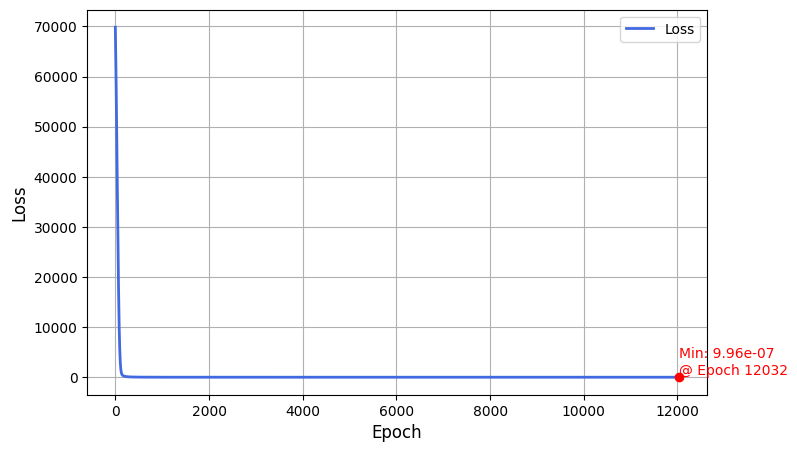

In [19]:
# Run the Neural IPF that returns the estimated matrix and scale factors
X_nipf_hat, nipf_scale_factors, loss_trace = nipf2(
                    torch.tensor(X),
                    [torch.tensor(p), torch.tensor(q)],
                    lr=0.01,
                    epochs=20000,
                    ) # results is kind of sensitive to the learning rate
X_nipf_hat = X_nipf_hat.numpy()
nipf_row_sum = X_nipf_hat.sum(axis=1)
nipf_col_sum = X_nipf_hat.sum(axis=0)

# Get the row and column scale factors
nipf_row_factors, nipf_col_factors = (
    scale.cpu().numpy() for scale in nipf_scale_factors
)

plot_loss_trace(loss_trace, save_path='./experiments/nnipf/figs/nipf_loss_trace_OD.pdf')

In [20]:
# Authors' implementation of IPF
i, row_factors, col_factors, row_errs, col_errs = do_ipf(X, p, q)
est_mat = np.diag(row_factors) @ X @ np.diag(col_factors)

Running IPF for max 1000 iterations
Iter 0: row err = 0.0000, col err = 8714.9395
Iter 1: row err = 525.3587, col err = 0.0000
Iter 2: row err = 0.0000, col err = 49.5060
Iter 3: row err = 4.2300, col err = 0.0000
Iter 4: row err = 0.0000, col err = 0.4387
Iter 5: row err = 0.0493, col err = 0.0000
Iter 6: row err = 0.0000, col err = 0.0053
Iter 7: row err = 0.0007, col err = 0.0000
Iter 8: row err = 0.0000, col err = 0.0001
Iter 9: row err = 0.0000, col err = 0.0000
Iter 10: row err = 0.0000, col err = 0.0000
Iter 11: row err = 0.0000, col err = 0.0000
Iter 12: row err = 0.0000, col err = 0.0000
Iter 13: row err = 0.0000, col err = 0.0000
Iter 14: row err = 0.0000, col err = 0.0000
Converged; stopping after 14 iterations


#### 50% Sparsity

In [132]:
# higher sparsity, same u and v
# need positive marginals for comparison to Poisson
X2 = generate_X(dist='uniform', m=m, n=n, seed=2, sparsity_rate=0.5, exact_rate=True, verbose=True)
# X2 = generate_X(dist='poisson', m=m, n=n, seed=2, sparsity_rate=0.5, exact_rate=True, verbose=True)
Y2 = generate_hourly_network(X2, expu, expv, model=model_choice, seed=seed)
p2 = np.sum(Y2, axis=1)
q2 = np.sum(Y2, axis=0)
print('zero rows:', np.sum(p2 == 0))
print('zero cols:', np.sum(q2 == 0))

Sampling X from uniform distribution
Num nonzero entries in X: 5000 out of 10000
zero rows: 0
zero cols: 0


Epoch 100 | Loss: 1.134543e+03
Epoch 200 | Loss: 4.758469e+01
Epoch 300 | Loss: 1.712904e+01
Epoch 400 | Loss: 8.841158e+00
Epoch 500 | Loss: 5.350524e+00
Epoch 600 | Loss: 3.545738e+00
Epoch 700 | Loss: 2.491788e+00
Epoch 800 | Loss: 1.824697e+00
Epoch 900 | Loss: 1.377690e+00
Epoch 1000 | Loss: 1.065203e+00
Epoch 1100 | Loss: 8.394895e-01
Epoch 1200 | Loss: 6.721150e-01
Epoch 1300 | Loss: 5.452719e-01
Epoch 1400 | Loss: 4.473479e-01
Epoch 1500 | Loss: 3.705324e-01
Epoch 1600 | Loss: 3.094281e-01
Epoch 1700 | Loss: 2.602223e-01
Epoch 1800 | Loss: 2.201686e-01
Epoch 1900 | Loss: 1.872542e-01
Epoch 2000 | Loss: 1.599809e-01
Epoch 2100 | Loss: 1.372156e-01
Epoch 2200 | Loss: 1.180904e-01
Epoch 2300 | Loss: 1.019321e-01
Epoch 2400 | Loss: 8.821179e-02
Epoch 2500 | Loss: 7.650985e-02
Epoch 2600 | Loss: 6.649055e-02
Epoch 2700 | Loss: 5.788183e-02
Epoch 2800 | Loss: 5.046254e-02
Epoch 2900 | Loss: 4.405108e-02
Epoch 3000 | Loss: 3.849742e-02
Epoch 3100 | Loss: 3.367695e-02
Epoch 3200 | Loss

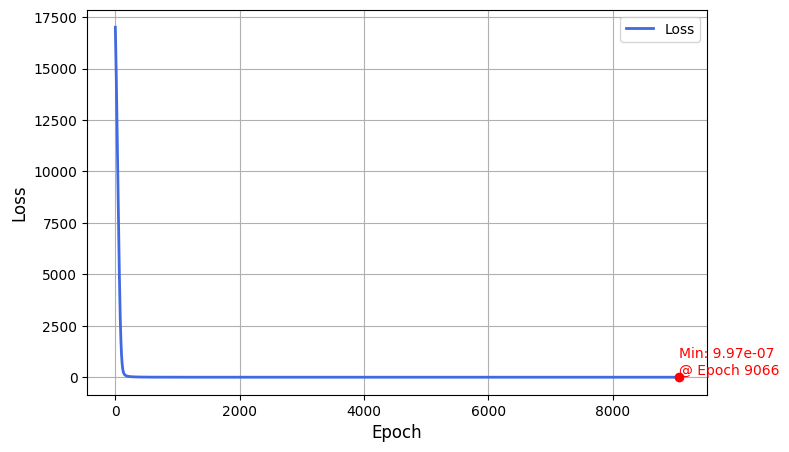

In [133]:
X_nipf_hat2, nipf_scale_factors2, loss_trace = nipf2(
                    torch.tensor(X2),
                    [torch.tensor(p2), torch.tensor(q2)],
                    lr=0.01,
                    epochs=20000
                    ) # results is kind of sensitive to the learning rate
X_nipf_hat2 = X_nipf_hat2.numpy()
nipf_row_factors2, nipf_col_factors2 = (
    scale.cpu().numpy() for scale in nipf_scale_factors2
)

plot_loss_trace(loss_trace, save_path='./experiments/nnipf/figs/nipf_loss_trace_OD2.pdf')


In [134]:
i, row_factors2, col_factors2, row_errs, col_errs = do_ipf(X2, p2, q2)
X_ipf_hat = np.diag(row_factors2) @ X2 @ np.diag(col_factors2)

Running IPF for max 1000 iterations
Iter 0: row err = 0.0000, col err = 4423.4620
Iter 1: row err = 408.7949, col err = 0.0000
Iter 2: row err = 0.0000, col err = 70.3593
Iter 3: row err = 13.9626, col err = 0.0000
Iter 4: row err = 0.0000, col err = 3.5259
Iter 5: row err = 0.8554, col err = 0.0000
Iter 6: row err = 0.0000, col err = 0.2414
Iter 7: row err = 0.0650, col err = 0.0000
Iter 8: row err = 0.0000, col err = 0.0193
Iter 9: row err = 0.0053, col err = 0.0000
Iter 10: row err = 0.0000, col err = 0.0016
Iter 11: row err = 0.0005, col err = 0.0000
Iter 12: row err = 0.0000, col err = 0.0001
Iter 13: row err = 0.0000, col err = 0.0000
Iter 14: row err = 0.0000, col err = 0.0000
Iter 15: row err = 0.0000, col err = 0.0000
Iter 16: row err = 0.0000, col err = 0.0000
Iter 17: row err = 0.0000, col err = 0.0000
Iter 18: row err = 0.0000, col err = 0.0000
Iter 19: row err = 0.0000, col err = 0.0000
Iter 20: row err = 0.0000, col err = 0.0000
Iter 21: row err = 0.0000, col err = 0.0000

#### 85% Sparsity

In [135]:
# even higher sparsity, same u and v
# need positive marginals for comparison to Poisson
X3 = generate_X(dist='uniform', m=m, n=n, seed=2, sparsity_rate=0.85, exact_rate=True, verbose=True)
Y3 = generate_hourly_network(X3, expu, expv, model=model_choice, seed=seed)
p3 = np.sum(Y3, axis=1)
q3 = np.sum(Y3, axis=0)
print('zero rows:', np.sum(p3 == 0))
print('zero cols:', np.sum(q3 == 0))

Sampling X from uniform distribution
Num nonzero entries in X: 1500 out of 10000
zero rows: 2
zero cols: 1


Epoch 100 | Loss: 9.723129e+01
Epoch 200 | Loss: 6.346248e+00
Epoch 300 | Loss: 2.019121e+00
Epoch 400 | Loss: 9.684541e-01
Epoch 500 | Loss: 5.680867e-01
Epoch 600 | Loss: 3.718730e-01
Epoch 700 | Loss: 2.611480e-01
Epoch 800 | Loss: 1.927347e-01
Epoch 900 | Loss: 1.475892e-01
Epoch 1000 | Loss: 1.162664e-01
Epoch 1100 | Loss: 9.367244e-02
Epoch 1200 | Loss: 7.686942e-02
Epoch 1300 | Loss: 6.406307e-02
Epoch 1400 | Loss: 5.410439e-02
Epoch 1500 | Loss: 4.622781e-02
Epoch 1600 | Loss: 3.990625e-02
Epoch 1700 | Loss: 3.476675e-02
Epoch 1800 | Loss: 3.053958e-02
Epoch 1900 | Loss: 2.702549e-02
Epoch 2000 | Loss: 2.407560e-02
Epoch 2100 | Loss: 2.157667e-02
Epoch 2200 | Loss: 1.944172e-02
Epoch 2300 | Loss: 1.760319e-02
Epoch 2400 | Loss: 1.600816e-02
Epoch 2500 | Loss: 1.461478e-02
Epoch 2600 | Loss: 1.338970e-02
Epoch 2700 | Loss: 1.230613e-02
Epoch 2800 | Loss: 1.134240e-02
Epoch 2900 | Loss: 1.048084e-02
Epoch 3000 | Loss: 9.706981e-03
Epoch 3100 | Loss: 9.008871e-03
Epoch 3200 | Loss

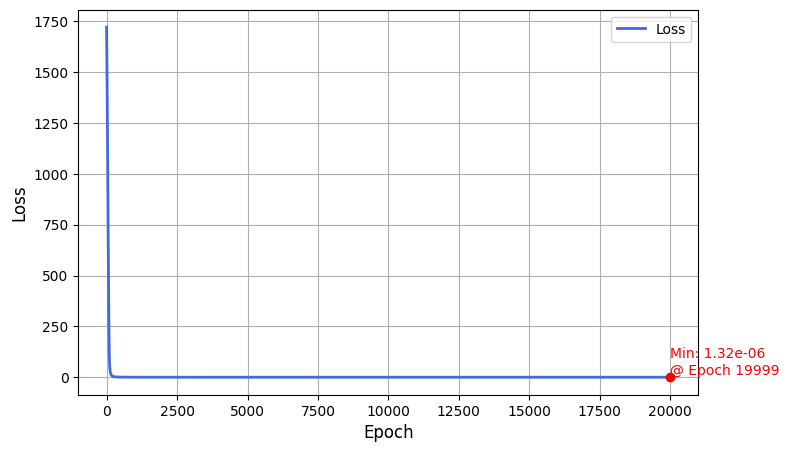

In [136]:
X_nipf_hat3, nipf_scale_factors3, loss_trace = nipf2(
                    torch.tensor(X3),
                    [torch.tensor(p3), torch.tensor(q3)],
                    lr=0.01,
                    epochs=20000
                    ) # results is kind of sensitive to the learning rate
X_nipf_hat3 = X_nipf_hat3.numpy()
nipf_row_factors3, nipf_col_factors3 = (
    scale.cpu().numpy() for scale in nipf_scale_factors3
)

plot_loss_trace(loss_trace, save_path='./experiments/nnipf/figs/nipf_loss_trace_OD3.pdf')


In [137]:
i, row_factors3, col_factors3, row_errs, col_errs = do_ipf(X3, p3, q3)
X_ipf_hat3 = np.diag(row_factors3) @ X3 @ np.diag(col_factors3)

Running IPF for max 1000 iterations
Iter 0: row err = 0.0000, col err = 1224.0808
Iter 1: row err = 314.6530, col err = 0.0000
Iter 2: row err = 0.0000, col err = 121.2507
Iter 3: row err = 54.9005, col err = 0.0000
Iter 4: row err = 0.0000, col err = 26.4013
Iter 5: row err = 13.1663, col err = 0.0000
Iter 6: row err = 0.0000, col err = 6.7743
Iter 7: row err = 3.5931, col err = 0.0000
Iter 8: row err = 0.0000, col err = 1.8511
Iter 9: row err = 1.0245, col err = 0.0000
Iter 10: row err = 0.0000, col err = 0.5216
Iter 11: row err = 0.3043, col err = 0.0000
Iter 12: row err = 0.0000, col err = 0.1574
Iter 13: row err = 0.0949, col err = 0.0000
Iter 14: row err = 0.0000, col err = 0.0505
Iter 15: row err = 0.0310, col err = 0.0000
Iter 16: row err = 0.0000, col err = 0.0167
Iter 17: row err = 0.0103, col err = 0.0000
Iter 18: row err = 0.0000, col err = 0.0056
Iter 19: row err = 0.0035, col err = 0.0000
Iter 20: row err = 0.0000, col err = 0.0019
Iter 21: row err = 0.0012, col err = 0.0

In [138]:
# What happens if we use the classical IPF on the sparse matrix?
# Notice how there is a division by zero warning: "invalid value encountered in scalar divide"
# This does not happen in the NIPF
X_ipfn_hat3 = ipfn_wrapper(X3.copy(), [p3, q3])

/opt/miniconda3/envs/popgen2/lib/python3.12/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in scalar divide
  if abs(m_ijk / ori_ijk - 1) > max_conv:


### Results

- Did IPF recover the true scaling factors?
- Was our proposed NIPF also able to recover the scaling factors?
- What is the effect of sparsity on results?

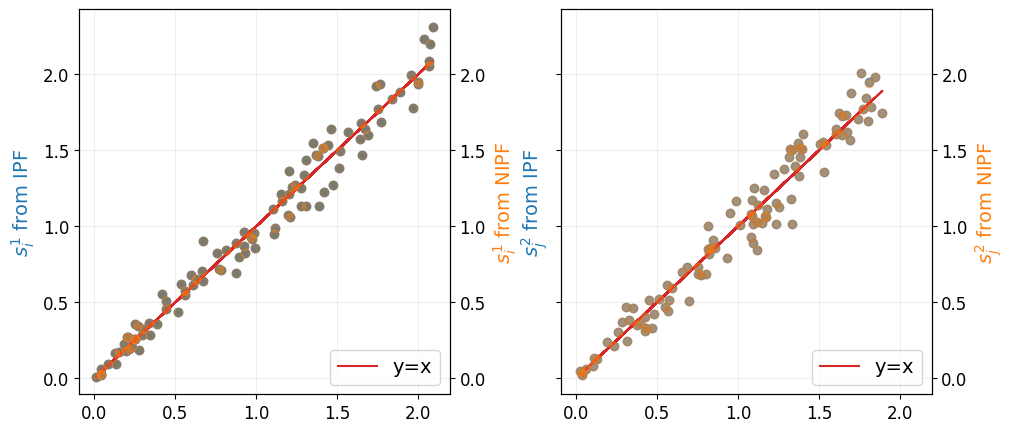

In [147]:
# plot sparsity=0.5 first to get xlim and ylim
fig, axes2 = visualize_ipf_vs_poisson_params(row_factors2, col_factors2,
                                             nipf_row_factors2, nipf_col_factors2,
                                            true_row_factors=expu, true_col_factors=expv, normalize=True, xaxis_label=None)
# fig.suptitle('Results for $m=100$, $n=100$, $\bar{X}$ sparsity rate=0.5', fontsize=16)
plt.savefig('experiments/nnipf/figs/synthetic_ipf_vs_poisson_s05.pdf', bbox_inches='tight')

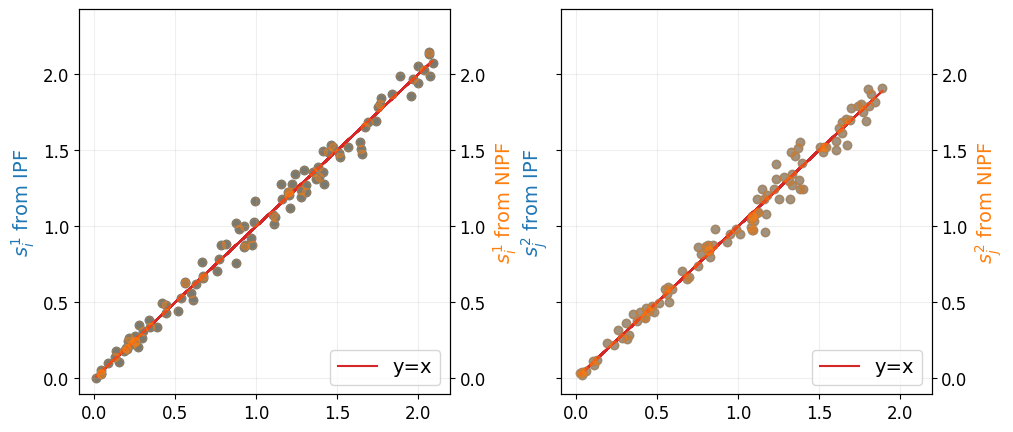

In [148]:
# use same xlim and ylim as previous plots
fig, axes = visualize_ipf_vs_poisson_params(row_factors, col_factors,
                                            nipf_row_factors, nipf_col_factors,
                                            true_row_factors=expu, true_col_factors=expv, normalize=True, xaxis_label=None,
                                            xlim=axes2[0].get_xlim(), ylim=axes2[0].get_ylim())
# fig.suptitle('Results for $m=100$, $n=100$, $X$ sparsity rate=0', fontsize=16)
plt.savefig('experiments/nnipf/figs/synthetic_ipf_vs_poisson_s00.pdf', bbox_inches='tight')

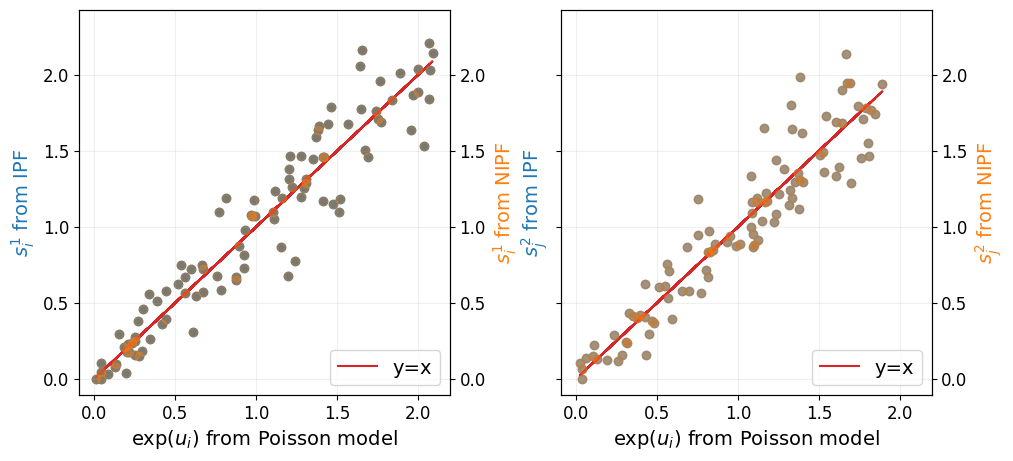

In [149]:
# use same xlim and ylim as previous plots
fig, axes = visualize_ipf_vs_poisson_params(row_factors3, col_factors3,
                                            nipf_row_factors3, nipf_col_factors3,
                                            true_row_factors=expu, true_col_factors=expv, normalize=True, xaxis_label='show',
                                            xlim=axes2[0].get_xlim(), ylim=axes2[0].get_ylim())
# fig.suptitle('Results for $m=100$, $n=100$, $X$ sparsity rate=0.85', fontsize=16)
plt.savefig('experiments/nnipf/figs/synthetic_ipf_vs_poisson_s085.pdf', bbox_inches='tight')